In [1]:
# ALL IMPORTS
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
import tensorflow as tf
from random import shuffle
import librosa
import pickle


In [2]:
# LOAD PROCESSED DATA
Training_Data_Load = pickle.load(open('Training_MMNIST.p', mode='rb'))
Validation_Data_Load = pickle.load(open('Validation_MMNIST.p', mode='rb'))

stackedTraining_Data, stackedTraining_Label = Training_Data_Load[0], Training_Data_Load[3]
stackedValidation_Data, stackedValidation_Label = Validation_Data_Load[0], Validation_Data_Load[3]


In [ ]:
# CREATE VARIABLES RELATED TO DATA
numberOfClasses = len(stackedTraining_Label[0])
batch_size = 64

nOfBatches_Train = int(len(stackedTraining_Data)/batch_size)
nOfBatches_Valid = int(len(stackedValidation_Data)/batch_size)


In [ ]:
# STRUCTURE CONV LAYER
def conv2D(inputTensor, outputTensor, kernelSize, strideSize):
    # CREATE WEIGHTS WITH STD 0.05
    weights = tf.Variable(tf.truncated_normal([kernelSize,kernelSize, int(inputTensor.shape[3]), outputTensor],stddev=.05))
    # CREATE CONV LAYER
    inputTensor = tf.nn.conv2d(inputTensor, weights, strides = [1,strideSize,strideSize,1],padding = 'SAME')
    # CREATE BIAS
    bias = tf.Variable(tf.zeros([outputTensor]))
    # ADD BIAS TO OUTCOME OF CONV
    inputTensor = tf.nn.bias_add(inputTensor, bias)
    # RETURN ACTIVATION AS RELU
    return tf.nn.relu(inputTensor)

In [ ]:
# STRUCTURE MAXPOOLING LAYER WITH PADDING = SAME
def maxPool(inputTensor, kernelSize, strideSize):
    # RETURN MAXPOOL
    return tf.nn.max_pool(inputTensor,ksize = [1,kernelSize,kernelSize,1],strides = [1,strideSize,strideSize,1],padding = 'SAME')

In [ ]:
# STRUCTURE FULLY CONNECTED LAYER
def fcl(inputTensor, outputNodes):
    # He initialisation
    inputNodes = int(inputTensor.shape[1])
    # HE INITIALISATION NOT USED
    sig = 0.05 #np.sqrt(2/inputNodes)
    # CREATE WEIGHTS
    weights = tf.Variable(tf.truncated_normal([inputNodes, outputNodes], stddev=sig))
    # CREATE BIAS
    bias = tf.Variable(tf.zeros([outputNodes]))
    # MULTIPLY INPUT BY WEIGHTS AND ADD BIAS
    inputTensor = tf.add(tf.matmul(inputTensor, weights), bias)
    # RETURN ACTIVATION AS RELU
    return tf.nn.relu(inputTensor)

In [ ]:
# STRUCTURE OUTPUT LAYER - THIS IS NEEDED CAUSE LAST LAYER IS SOFTMAX ACTIVATION
def output(inputTensor, outputNodes):
    inputNodes = int(inputTensor.shape[1])
    # CREATE WEIGHTS
    weights = tf.Variable(tf.truncated_normal([inputNodes, outputNodes], stddev=0.05))
    # CREATE BIAS
    bias = tf.Variable(tf.zeros([outputNodes]))
    # RETURN MULTIPLIED WEIGHTS, INPUT AND ADDED BIAS
    return tf.add(tf.matmul(inputTensor, weights), bias)

In [ ]:
# FLATTEN THE OUTPUT OF THE CONV NET TO GET FEATURES AS 1D ARRAY
def dense(inputTensor):
    inputShape = inputTensor.get_shape().as_list()
    return tf.reshape(inputTensor, [-1, inputShape[1] * inputShape[2] * inputShape[3]])

In [ ]:
# STRUCTURE THE WHOLE INITIAL CONVOLUTIONAL NET
def conv2DNet(inputTensor, keep_prob):
    print("CONV")
    print(inputTensor.shape)
    inputTensor = conv2D(inputTensor, 32, 5,1) 
    inputTensor = maxPool(inputTensor, 3,2) 

    print(inputTensor.shape)
    inputTensor = conv2D(inputTensor, 64, 4,1) 
    inputTensor = maxPool(inputTensor, 2,2) 
    
    print(inputTensor.shape)
    inputTensor = conv2D(inputTensor, 64, 3,1) 
    inputTensor = maxPool(inputTensor,  2,2) 
    
    print(inputTensor.shape)
    inputTensor = conv2D(inputTensor, 128, 3,1) 
    inputTensor = maxPool(inputTensor, 2,2) 
    
    print(inputTensor.shape)
    inputTensor = conv2D(inputTensor, 256, 3,1) 
    inputTensor = maxPool(inputTensor,  2,2) 
    
    # ADD DROPOUT
    inputTensor = tf.nn.dropout(inputTensor, keep_prob)
    # DENSE / FLATTEN
    inputTensor = dense(inputTensor)
    print(inputTensor.shape)
    # RETURN OUTPUT OF CONV
    return inputTensor

# CREATE THE MLP STRUCTURE
def mlp(inputTensor, keep_prop):
    print("MLP")
    inputTensor = fcl(inputTensor, 1024)
    inputTensor = tf.nn.dropout(inputTensor, keep_prob)
    print(inputTensor.shape)
    inputTensor = fcl(inputTensor, 1024)
    inputTensor = tf.nn.dropout(inputTensor, keep_prob)
    print(inputTensor.shape)
    # RETURN OUTPUT OF MLP
    return output(inputTensor, numberOfClasses)


In [ ]:
# THE TRAINING LOOP
import time
start_time = time.time()

print("Start Training")
# LR IS DEFAULT ADAM - learning_rate=0.001

# ARRAYS FOR GRAPH
trainCost = []
trainAcc = []
validCost = []
validAcc = []

validation_threshold = [0.7, 0.8, 0.9]


# RESET GRAPH/WEIGHTS FOR RETRAINING
tf.reset_default_graph()
# EPOCHS TO TRAIN FOR
epochs = 60
# DROPOUT PROPABILITY
keep_probability = 0.5

# VARIABLES FOR GRAPH
# NONE = BATCH SIZE PRESENTED TO GRAPH
x = tf.placeholder(tf.float32, [None, 128, 44, 1], name="x")
y = tf.placeholder(tf.float32, [None, numberOfClasses], name="y")
keep_prob = tf.placeholder(tf.float32, name="keep_prob")

# CONVOLUTIONAL LOGIT - SAVED 
conv_logit = conv2DNet(x, keep_prob)
conv_logit = tf.identity(conv_logit, name='convLogits')

# MLP LOGIT - SAVED
mlp_logit = mlp(conv_logit, keep_prob)
mlp_logit = tf.identity(mlp_logit, name='mlpLogits')

# COST FUNCTION AND OPTIMIZER INITIALIZED
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=mlp_logit, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# PREDICTION AND ACCURACY FUNCTION
correct_pred = tf.equal(tf.argmax(mlp_logit, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

earlystop_index = 0
earlystop_condition = validation_threshold[earlystop_index]
epoch_reached = []

with tf.Session() as sess:
    # INIT ALL VARIABLES
    sess.run(tf.global_variables_initializer())
    # SET TRAINING DATA
    data = stackedTraining_Data
    targetVector = stackedTraining_Label
    # SET VALIDATION DATA
    dataVal = stackedValidation_Data
    targetVectorVal = stackedValidation_Label
    # SET THE BATCHES
    trainBatch = nOfBatches_Train+1
    validBatch = nOfBatches_Valid+1
    # TRAIN FOR EPOCHS
    for epoch in range(1,epochs+1):
        print('Start Epoch ' + str(epoch))

        # TRAIN 
        avgLossHolder = 0
        avgAccHolder = 0
        for i in range(trainBatch): 
            batch_x = data[i*batch_size:(i+1)*batch_size]
            batch_y = targetVector[i*batch_size:(i+1)*batch_size]

            # RUN THE OPTIMIZER
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: keep_probability})
            # GET THE LOSS AND ACCURACY
            currTrainLoss, currTrainAcc = sess.run([cost,accuracy], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
            avgLossHolder += currTrainLoss
            avgAccHolder += currTrainAcc

        avgLossHolder /= trainBatch
        avgAccHolder /= trainBatch
        trainCost.append(avgLossHolder)
        trainAcc.append(avgAccHolder)
        print('Loss: {:>8.4f}, Training Accuracy: {:>8.6f}'.format(avgLossHolder, avgAccHolder))

        # VALIDATION
        avgLossHolder = 0
        avgAccHolder = 0

        for i in range(validBatch): 
            batch_x = dataVal[i*batch_size:(i+1)*batch_size]
            batch_y = targetVectorVal[i*batch_size:(i+1)*batch_size]
            # GET THE LOSS AND ACCURACY
            currValidLoss, currValidAcc = sess.run([cost,accuracy], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
            avgLossHolder += currValidLoss
            avgAccHolder += currValidAcc

        avgLossHolder /= validBatch
        avgAccHolder /= validBatch
        validCost.append(avgLossHolder)
        validAcc.append(avgAccHolder)

        print('Loss: {:>8.4f}, Validation Accuracy: {:>8.6f}'.format(avgLossHolder, avgAccHolder))
        print('Epoch ' + str(epoch) + ' done')
        print("Condition is",earlystop_condition)
        if(avgAccHolder > earlystop_condition or epoch == epochs):

            print("Threshold reached, feeding samples through for softmax prediction")
            epoch_reached.append(epoch-1)

            training_hold = []
            training_hold_y = []
            validation_hold = []
            validation_hold_y = []
            
            # Training output
            for i in range(trainBatch): 
                batch_x = data[i*batch_size:(i+1)*batch_size]
                batch_y = targetVector[i*batch_size:(i+1)*batch_size]
                training_batch = sess.run(mlp_logit, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})

                if(len(training_hold) == 0):
                    training_hold = training_batch
                    training_hold_y = batch_y
                else:
                    training_hold = np.concatenate((training_hold,training_batch), axis=0)
                    training_hold_y = np.concatenate((training_hold_y,batch_y), axis=0)

            # Validation output
            for i in range(validBatch): 
                batch_x = dataVal[i*batch_size:(i+1)*batch_size]
                batch_y = targetVectorVal[i*batch_size:(i+1)*batch_size]
                validation_batch = sess.run(mlp_logit, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
                if(len(validation_hold) == 0):
                    validation_hold = validation_batch
                    validation_hold_y = batch_y
                else:
                    validation_hold = np.concatenate((validation_hold,validation_batch), axis=0)
                    validation_hold_y = np.concatenate((validation_hold_y,batch_y), axis=0)     

            pickle.dump((training_hold, training_hold_y), open('AC_Training_' +str(earlystop_condition)+'.p', 'wb'))
            pickle.dump((validation_hold, validation_hold_y), open('AC_Validation_'+str(earlystop_condition)+'.p', 'wb'))
            print("Done saving AC",earlystop_condition)
            
            # See if we should keep going, if there are more thresholds to meet
            if(earlystop_index < len(validation_threshold)-1):
                # keep going, reset condition
                earlystop_index += 1
                earlystop_condition = validation_threshold[earlystop_index]
                print("Next condition:",earlystop_condition)
            else:
                print("All conditions saved")
                if(epoch == epochs):
                    print("Saved on last epoch")
                break
    print("Training done - took %s seconds" % (time.time() - start_time)) 
    # SAVE THE MODEL
    #saver = tf.train.Saver()
    #save_path = saver.save(sess, './audio_classificationMNIST')
    # SAVE THE DATAFILE


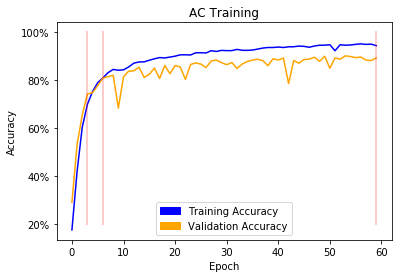

In [3]:
# PLOT THE TRAINING AND MARK WHERE A SOFTMAX PREDICTION WAS SAVED
plt.figure(2)
plt.plot(trainAcc, color='b', alpha=1)
plt.plot(validAcc, color='orange', alpha=1)

for epoch in epoch_reached:
    plt.plot([epoch, epoch], [1, 0.2], 'k-', color='r', alpha=0.2, lw=2)

plt.title('AC Training')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
blue = mpatches.Patch(color='b', label='Training Accuracy')
orange = mpatches.Patch(color='orange', label='Validation Accuracy')
plt.legend(handles=[blue,orange])
plt.show()

In [2]:
# PRINT THE ACCURACY OF ALL AUDIO SOFTMAX PREDICTIONS

def confirmAccuracy(per):
    print("Accuracy of AC",per)
    
    td, tl = pickle.load(open('AC_Training_'+per+'.p', mode='rb'))
    vd, vl = pickle.load(open('AC_Validation_'+per+'.p', mode='rb'))
    
    tcnt = 0
    for i in range(len(td)):
        if(np.argmax(td[i]) == np.argmax(tl[i])):
            tcnt += 1
    print("trainExamples",len(td))
    print("trainAcc",tcnt/len(td))
    vcnt = 0
    for i in range(len(vd)):
        if(np.argmax(vd[i]) == np.argmax(vl[i])):
            vcnt += 1
    print("validExamples",len(vd))
    print("validAcc",vcnt/len(vd))
    print("")

    
confirmAccuracy("0.7")    
confirmAccuracy("0.8")    
confirmAccuracy("0.9")

Accuracy of AC 0.7
trainExamples 20116
trainAcc 0.7317061045933585
validExamples 3549
validAcc 0.7094956325725557

Accuracy of AC 0.8
trainExamples 20116
trainAcc 0.8368462915092464
validExamples 3549
validAcc 0.8140321217244294

Accuracy of AC 0.9
trainExamples 20116
trainAcc 0.9457645655199841
validExamples 3549
validAcc 0.8940546632854325

